**You can find this code on Github via this [link](https://github.com/Julfyy/Julfyy-Coursera-DL-course)**
# Data set description


In this competition, I am challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. There's a dataset of 10,000 tweets that were hand classified. 

Each sample in the train and test set has the following information:
* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

Files:
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

Columns:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


Imports

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import nltk
from nltk.corpus import stopwords
import re 
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU, LSTM, RNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

from wordcloud import WordCloud

# Get data

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [5]:
!kaggle competitions download -c nlp-getting-started


  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 110MB/s]


In [6]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train_data=pd.read_csv('/content/train.csv')
train_data.head()

In [ ]:
test_data=pd.read_csv('/content/test.csv')
test_data.head()

# Double check whether the data is balanced

It is completely balanced.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


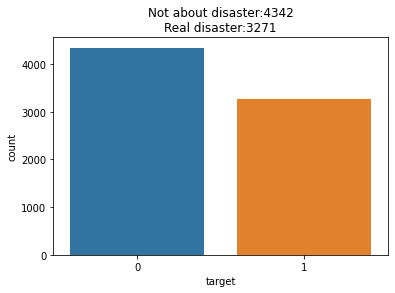

In [10]:
sns.countplot(train_data['target'])
plt.title('Not about disaster:'+str(train_data.target.value_counts()[0])+'\n'+
         'Real disaster:'+str(train_data.target.value_counts()[1]))
plt.show()


**let's also see word length distribution in our dataset.**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


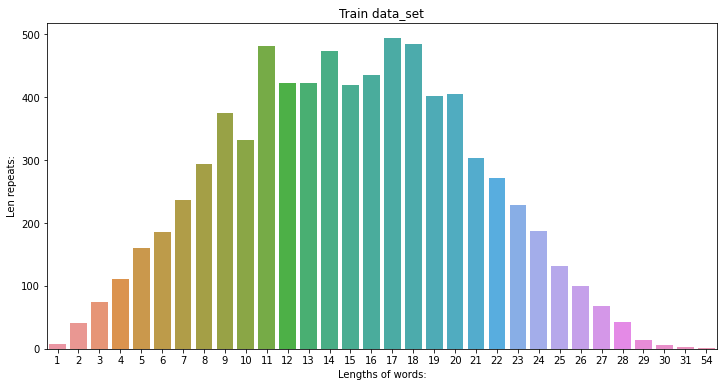

In [11]:
def words_len(arr, text):
    word_len = []
    for i in arr:
        word_len.append(len(i.split(' ')))

    plt.figure(figsize=(12,6))
    sns.countplot(word_len)
    plt.xlabel("Lengths of words:")
    plt.ylabel('Len repeats:')
    plt.title(text)
    plt.show()
    
words_len(train_data['text'],"Train data_set")

# Exploratory Data Analysis (EDA)
The data contains too many Null values in keyword and location fields so can just drop those columns

In [12]:
train_data.drop(['keyword','location'], axis=1, inplace=True)
test_data.drop(['keyword','location'], axis=1, inplace=True)

**Now time to find most popular words in dataset:**

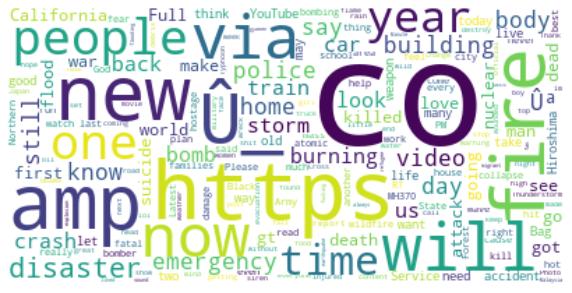

In [14]:
def show_words(arr):
    tmp = ''
    for i in arr:
        tmp +=i
    
    wc = WordCloud(collocations = False, background_color = 'white').generate(tmp)
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')

    plt.axis("off")

    plt.show()

show_words(train_data['text'])

As can we see - there's lots of meaningless words and other symbols.
We must get rid of all stopwords, words with len < 4, brecets etc.

Also convert all text to the lower case and delete all non English letters and all numbers

In [ ]:
nltk.download('stopwords')

In [17]:
swords=set(stopwords.words('english'))

def clear_txt(text):
    h_str = text.lower()
    h_str = re.sub(r'(http|https)?\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','',h_str)
    
    h_str = re.sub(r'\{[^)]*\}', '', h_str)
    h_str = re.sub(r'\([^)]*\)', '', h_str)
    
    h_str = re.sub('[^a-zA-Z]', ' ', h_str)
    
    tokens = [w for w in h_str.split() if not w in swords] 
    
    res = []
    for i in tokens:
        if len(i) >=4:
            res.append(i)
    return (" ".join(res)).strip()

In [18]:
clean_train = []
for i in train_data['text']:
    clean_train.append(clear_txt(i))

**Lets see how does data look like now**

In [22]:
print("Before: ", train_data['text'][10])
print("After: ", clean_train[10])

Before:  Three people died from the heat wave so far
After:  three people died heat wave


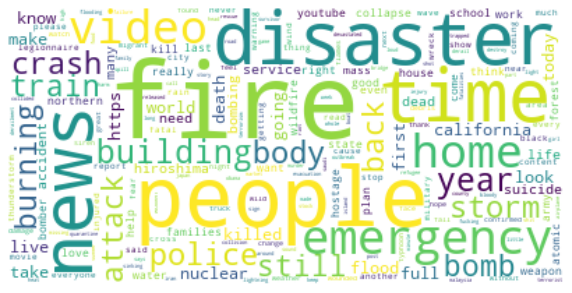

In [23]:
show_words(clean_train)

In [24]:
clean_test = []
for i in test_data['text']:
    clean_test.append(clear_txt(i))

# Prepare data for training

Divide data into a train (80%) and a validation set (20%)

In [30]:
X_train,X_valid,y_train,y_valid = train_test_split(clean_train, train_data['target'], test_size = 0.2, random_state = 40)
print(f"Train size: {len(X_train)}, {len(y_train)}")
print(f"Validation size: {len(X_valid)}, {len(y_valid)}")

Train size: 6090, 6090
Validation size: 1523, 1523


# The next step is word tokenizing


In [31]:
max_len = 20

tokenizer=Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_valid=tokenizer.texts_to_sequences(X_valid)

X_test=tokenizer.texts_to_sequences(clean_test)

X_train=pad_sequences(X_train,maxlen=max_len,padding='post')
X_valid=pad_sequences(X_valid,maxlen=max_len,padding='post')

X_test=pad_sequences(X_test,maxlen=max_len,padding='post')

voc = len(tokenizer.word_index) + 1
print("Vocabluary size is ", voc)

Vocabluary size is  12775


**Next we must categorize our data (about disaster and fake)**

In [ ]:
y_train=to_categorical(y_train,num_classes=2)
y_valid=to_categorical(y_valid,num_classes=2)

print(y_train.shape)
print(y_valid.shape)

# First model

The first model consists of 1 LSTM layer. 

To prevent the perpetual increase in loss, we use the relu activation function.
Output is sigmoid becouse we have binar clasifications. 
**Same to the next models.**

In [ ]:
K.clear_session()

model1 = Sequential()
model1.add(Embedding(voc,100,input_length=max_len,trainable=True,mask_zero=True))
model1.add(LSTM(300,dropout=0.1,recurrent_dropout=0.2))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(2,activation='sigmoid'))
model1.summary()

**Compile our model, using most popular and simple optimazer for RNN - ADAM.**

And also divide data into batches with size 650. If this value is lower, then the growth of loss is too rapid. You can put more, but it is important not to cross the line when 30 epochs are not enough for full-fledged learning.

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

h1 = model1.fit(x=np.array(X_train), y=np.array(y_train),batch_size = 650, epochs=30,
                   validation_data=(np.array(X_valid),np.array(y_valid)))

# 1st result
On graphics we can see that the validation loss is high, but it's normal

Accuracy in between 0.75 and 0.8.

That is pretty good result for the first try

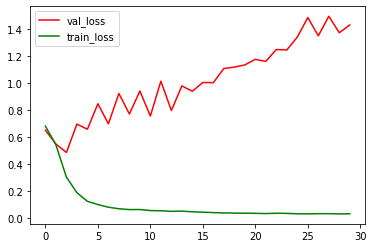

In [36]:
plt.plot(h1.history['val_loss'],'r',label='val_loss')
plt.plot(h1.history['loss'],'g',label='train_loss')
plt.legend()

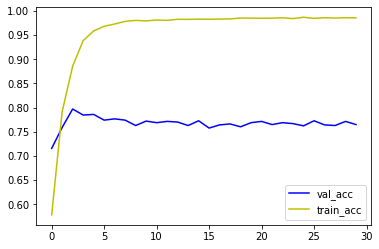

In [37]:
plt.plot(h1.history['val_acc'],'b',label='val_acc')
plt.plot(h1.history['acc'],'y',label='train_acc')
plt.legend()

# Model 2
**Second model with 1 GRU layer.**

Hyperparameters are same as before

In [ ]:
model2=Sequential()
model2.add(Embedding(voc,100,input_length=max_len,trainable=True,mask_zero=True))
model2.add(GRU(300,dropout=0.1,recurrent_dropout=0.2))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(2,activation='sigmoid'))
model2.summary()

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
h2=model2.fit(x=np.array(X_train),y=np.array(y_train),batch_size=650,epochs=30,
          validation_data=(np.array(X_valid),np.array(y_valid)))

# Second result
Graphs show that the validation loss is still high, but it's quite smaller compared to the 1st model

The accuracy in between 0.75 and 0.8. Almost the same as in the previous model


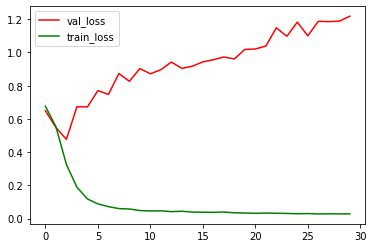

In [40]:
plt.plot(h2.history['val_loss'],'r',label='val_loss')
plt.plot(h2.history['loss'],'g',label='train_loss')
plt.legend()

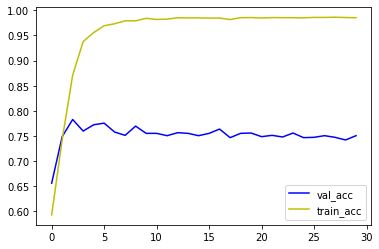

In [41]:
plt.plot(h2.history['val_acc'],'b',label='val_acc')
plt.plot(h2.history['acc'],'y',label='train_acc')
plt.legend()

# 3rd model
**Let's try multilayered LSTM model**

I'm adding 4 LSTM layers with size 350,150,50.
Batch size is 200 now. We have greater losses, but the quality of education must increase.

Other hyperparameters are the same.

In [ ]:
model3=Sequential()
model3.add(Embedding(voc,100,input_length=max_len,trainable=True,mask_zero=True))
model3.add(LSTM(350,dropout=0.1,recurrent_dropout=0.2,return_sequences=True))
model3.add(LSTM(150,dropout=0.1,recurrent_dropout=0.2,return_sequences=True))
model3.add(LSTM(50,dropout=0.1,recurrent_dropout=0.2))
model3.add(Dense(64,activation='relu'))
model3.add(Dense(2,activation='sigmoid'))
model3.summary()

model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
h3=model3.fit(x=np.array(X_train),y=np.array(y_train),batch_size=200,epochs=30,
          validation_data=(np.array(X_valid),np.array(y_valid)))

# 3rd result
On graphs we see that validation loss has got even higher.

The accuracy is in the same range - between 0.74 and 0.8

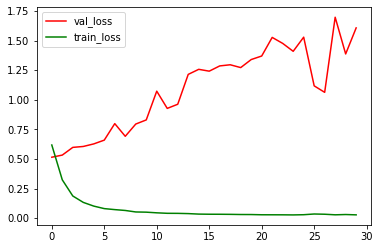

In [44]:
plt.plot(h3.history['val_loss'],'r',label='val_loss')
plt.plot(h3.history['loss'],'g',label='train_loss')
plt.legend()

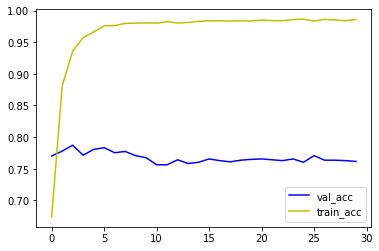

In [45]:
plt.plot(h3.history['val_acc'],'b',label='val_acc')
plt.plot(h3.history['acc'],'y',label='train_acc')
plt.legend()

# Final submission 

**All models have similar accuracies, but the third one seem to be the best, so I'll submit the last results that we got**


In [46]:
predict_help = model3.predict(X_test)
prediction = [0 if i[0]>=0.5 else 1 for i in predict_help]
test_data['target'] = prediction

sub = test_data[['id', 'target']]
sub.to_csv('Submission.csv', index=False)


Start write into csv
End write into csv
